In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

/bin/bash: line 1: google-drive-ocamlfuse: command not found


In [3]:
import os
os.chdir('/content/drive/MyDrive/Medical Images Project (X Ray)/Brian Tumor')
!pwd

/content/drive/MyDrive/Medical Images Project (X Ray)/Brian Tumor


In [4]:
BrainTumor_path = "/content/drive/MyDrive/Medical Images Project (X Ray)/Brian Tumor/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor"
Healty_path = "/content/drive/MyDrive/Medical Images Project (X Ray)/Brian Tumor/Brain Tumor Data Set/Brain Tumor Data Set/Healthy"

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

## Visualizing data

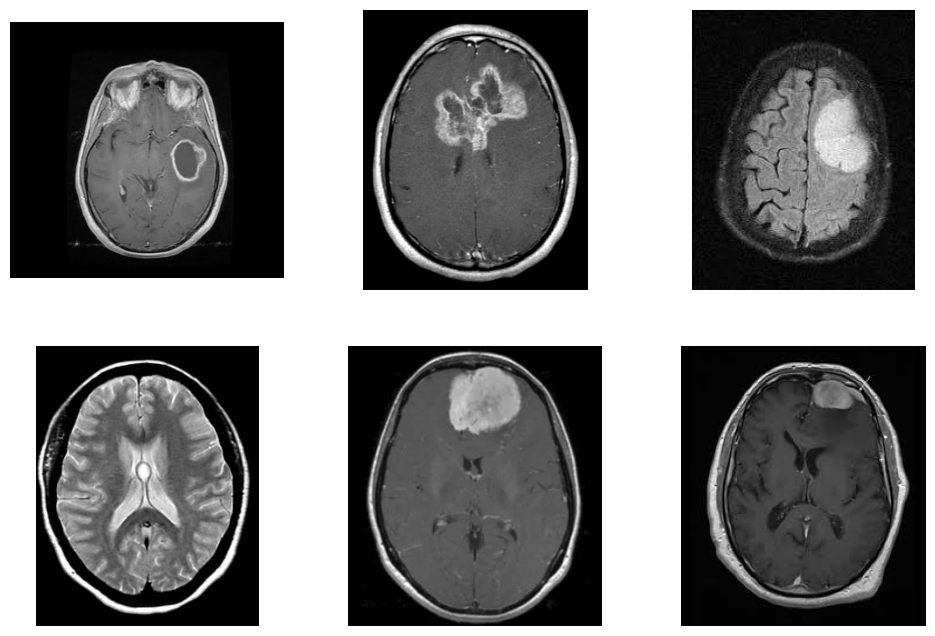

In [6]:
# Beyin tümörü resimleri
image_files_tumor = [file for file in os.listdir(BrainTumor_path)]

num_images = min(6, len(image_files_tumor))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(BrainTumor_path, image_files_tumor[i])
    img = mpimg.imread(image_path)

    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

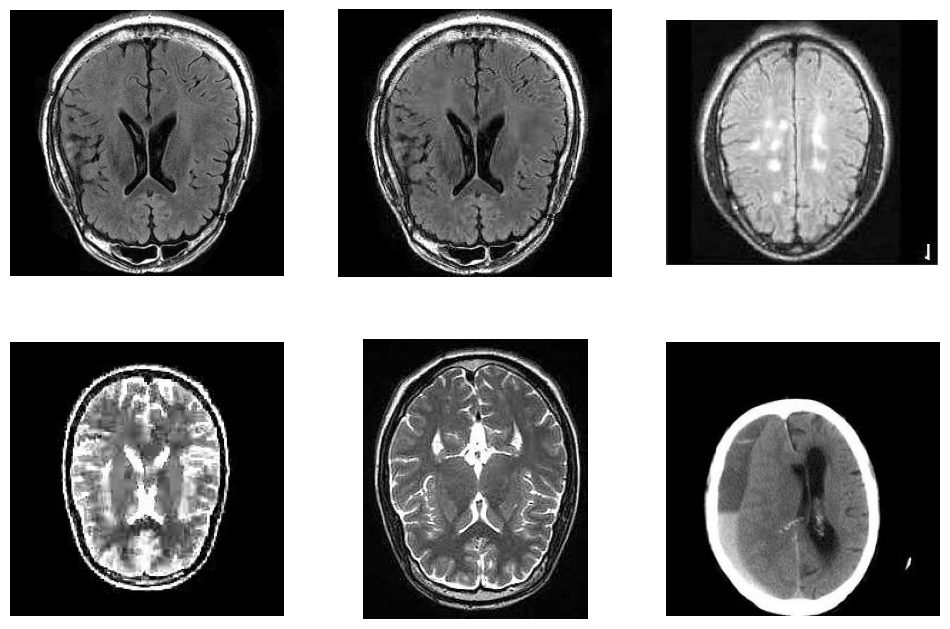

In [7]:
# Sağlıklı resim
image_files_healty = [file for file in os.listdir(Healty_path)]

num_images = min(6, len(image_files_healty))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(Healty_path, image_files_healty[i])
    img = mpimg.imread(image_path)

    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [8]:
print("Number of Tumor Images in the directory:",len(image_files_tumor))
print("Number of Healthy Images in the directory:",len(image_files_healty))

Number of Tumor Images in the directory: 2513
Number of Healthy Images in the directory: 2087


## Image Data Generator

In [9]:
# Define the image size and batch size
img_height, img_width = 224, 224
batch_size = 512

# ImageDataGenerator object yaratma
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2,
)

# training dataset yükleme

train_dataset = datagen.flow_from_directory(
    '/content/drive/MyDrive/Medical Images Project (X Ray)/Brian Tumor/Brain Tumor Data Set/Brain Tumor Data Set',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    interpolation='bilinear',
    subset='training',
)
# validation dataset yükleme
validation_dataset = datagen.flow_from_directory(
    '/content/drive/MyDrive/Medical Images Project (X Ray)/Brian Tumor/Brain Tumor Data Set/Brain Tumor Data Set',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    interpolation='bilinear',
    subset='validation',
)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


## Graph Plotting Function

In [10]:
# plot metrics
def plot_metrics(history):
    metrics = ["loss", "accuracy", "prc", "Precision", "Recall"]
    plt.figure(figsize=(16, 10))

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()

        plt.subplot(3,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(True)


        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

        plt.legend()

## CNN Model

In [11]:
def build_model(metrics, epoch = 20):
    # Yeni bir başlangıç yapmak için önceki model (previous model) oturumlarını temizleme
    tf.keras.backend.clear_session()

    # Sequential model başlatma
    model = tf.keras.models.Sequential()

    # 16 filtre (filters), 3x3 çekirdek (kernel) ve 'relu' aktivasyon işlevi (activation function) içeren 2D boyutlu bir evrişim katmanı (convolution layer) ekleme
    model.add(tfl.Conv2D(16, (3, 3), activation='relu', padding = "same", input_shape=(img_height, img_width, 1)))

    # Çıkış hacminin uzamsal boyutlarını azaltmak için maksimum havuzlama katmanı (max pooling layer) ekleme
    model.add(tfl.MaxPooling2D((2, 2)))

    # Başka bir evrişim (convolution) ve maksimum havuzlama katmanı (max pooling layer) ekleme
    model.add(tfl.Conv2D(8, (3, 3), activation='relu', padding = "same"))
    model.add(tfl.MaxPool2D((2,2)))

    # Tek bir uzun özellik vektörü (feature vector) oluşturmak için önceki katmandaki (previous layer) tensör çıktısını düzleştirme (Flatten)
    model.add(tfl.Flatten())

    # 8 nöron (neurons) ve 'relu' aktivasyon fonksiyonu (activation function) içeren yoğun bir katman ekleme
    model.add(tfl.Dense(8, activation='relu'))

    # Önceki katmanın etkinleştirmelerini normalleştirmek (normalization) için toplu normalleştirme katmanı ekleme
    model.add(tfl.BatchNormalization())

    # Aşırı uyumu (overfitting) önlemek için bir bırakma katmanı (dropout layer) ekleme
    model.add(tfl.Dropout(0.3))

    # Çıkış katmanını tek bir nöronla (binary classification) ve 'sigmoid' aktivasyon fonksiyonuyla ekleme
    model.add(tfl.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

    model.summary()

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epoch, verbose=1)

    plot_metrics(history)

    # Eğitilen modeli (trained model) ve geçmişini (history) döndürme
    return model, history

In [12]:
# Modelin değerlendirileceği metrikleri (metrics) tanımlayın
metrics = [ tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.F1Score(name='F1'),
            tf.keras.metrics.Recall(name='Recall'),
            tf.keras.metrics.Precision(name='Precision'),
            tf.keras.metrics.AUC(name='prc', curve='PR')]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

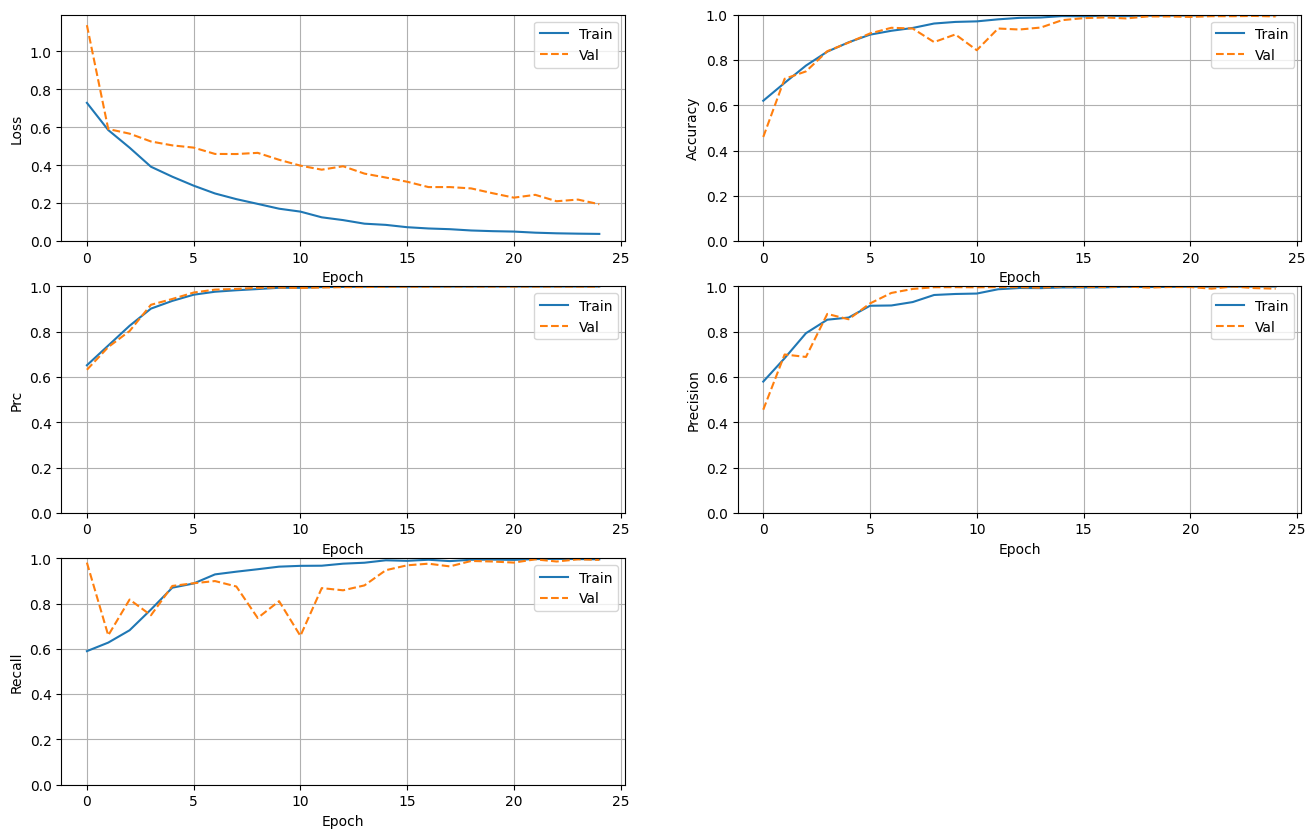

In [13]:
model, history = build_model(metrics, epoch = 25)

In [14]:
model.evaluate(validation_dataset)

2/2 [==============================] - 5s 2s/step - loss: 0.1946 - accuracy: 0.9924 - F1: 0.6243 - Recall: 0.9928 - Precision: 0.9904 - prc: 0.9990


[0.19461791217327118,
 0.9923830032348633,
 array([0.6242515], dtype=float32),
 0.9928057789802551,
 0.9904305934906006,
 0.9990441799163818]

In [15]:
# getting labels of the validation_dataset for plotting confusion matrix
steps = validation_dataset.samples // validation_dataset.batch_size
if validation_dataset.samples % validation_dataset.batch_size > 0:
    steps += 1

images_list = []
y_true = []

for i, (images, labels) in enumerate(validation_dataset):
    if i >= steps:
        break
    images_list.extend(images)
    y_true.extend(labels)

images_array = np.array(images_list)
y_true = np.array(y_true)

29/29 [==============================] - 1s 13ms/step


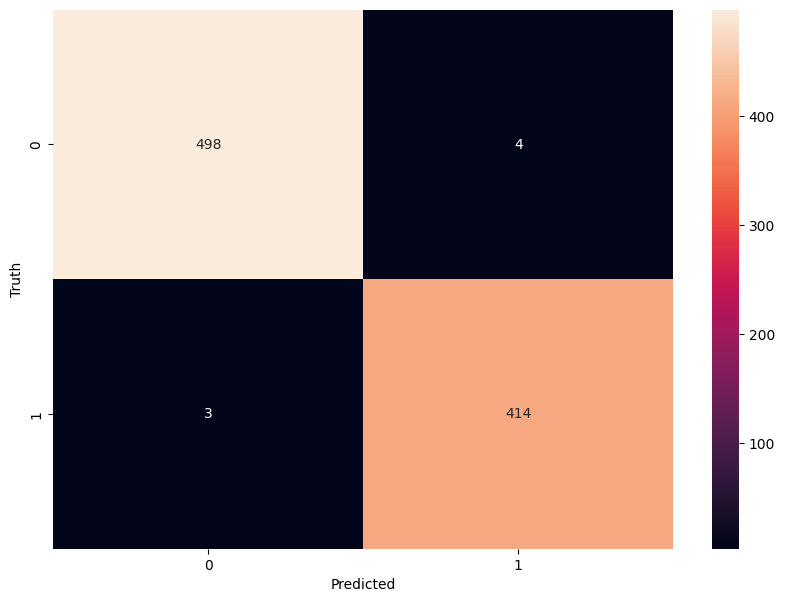

In [16]:
# getting predictions
y_pred = model.predict(images_array)
y_pred = (y_pred >= 0.5).astype(int)
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [17]:
# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       502
         1.0       0.99      0.99      0.99       417

    accuracy                           0.99       919
   macro avg       0.99      0.99      0.99       919
weighted avg       0.99      0.99      0.99       919

